In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

C:\Users\Kamisi Oduleye\AppData\Roaming\Python\Python313\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.10.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [7]:
df = pd.read_csv("data/Train_data.csv")
df.columns = df.columns.str.strip()
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [8]:
def transform_windows(val):
    val = str(val).strip()
    if val == '.' or val == 'nan':
        return 0
    elif '>=' in val:
        return 10
    else:
        try:
            return int(val)
        except:
            return 0

df['NumberOfWindows'] = df['NumberOfWindows'].apply(transform_windows)

In [9]:
df['Building Dimension'] = df['Building Dimension'].fillna(df['Building Dimension'].median())
df['Date_of_Occupancy'] = df['Date_of_Occupancy'].fillna(df['Date_of_Occupancy'].mode()[0])
df['Garden'] = df['Garden'].fillna(df['Garden'].mode()[0])
df['Geo_Code'] = df['Geo_Code'].fillna('Unknown')

In [10]:
df['Building_Age'] = df['YearOfObservation'] - df['Date_of_Occupancy']
df['Is_Long_Term'] = (df['Insured_Period'] == 1).astype(int)
df_clean = df.drop(['Customer Id', 'Geo_Code'], axis=1)

C:\Users\Kamisi Oduleye\AppData\Local\Temp\ipykernel_16968\2062740851.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Claim', data=df_clean, palette='viridis')


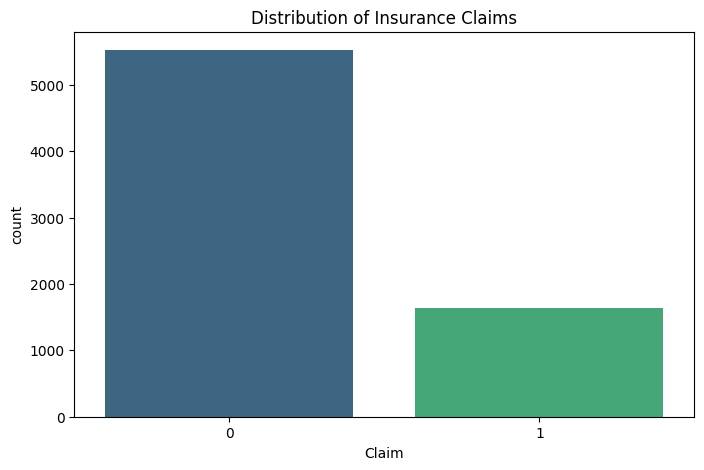

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Claim', data=df_clean, palette='viridis')
plt.title('Distribution of Insurance Claims')
plt.show()

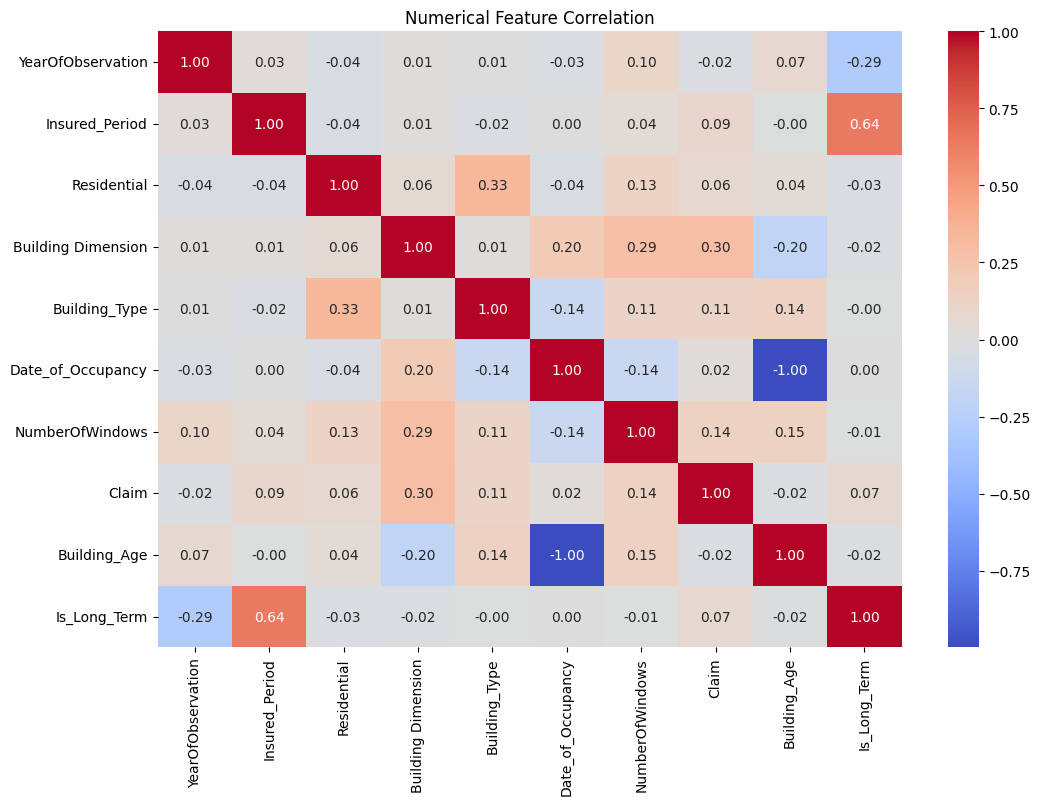

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Numerical Feature Correlation')
plt.show()

C:\Users\Kamisi Oduleye\AppData\Local\Temp\ipykernel_16968\308440562.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Building_Type', y='Claim', data=df_clean, ci=None)


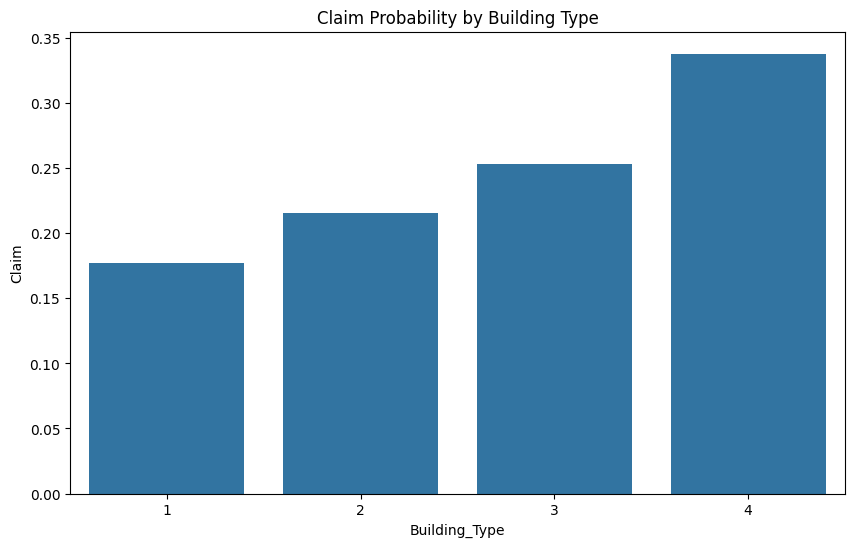

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Building_Type', y='Claim', data=df_clean, ci=None)
plt.title('Claim Probability by Building Type')
plt.show()

In [14]:
le = LabelEncoder()
categorical_cols = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement']

for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

df_clean.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Claim,Building_Age,Is_Long_Term
0,2013,1.0,0,0,1,1,1,290.0,1,1960.0,0,0,53.0,1
1,2015,1.0,0,1,0,0,0,490.0,1,1850.0,4,0,165.0,1
2,2014,1.0,0,0,1,1,1,595.0,1,1960.0,0,0,54.0,1
3,2013,1.0,0,1,1,1,1,2840.0,1,1960.0,0,0,53.0,1
4,2014,1.0,0,1,0,0,0,680.0,1,1800.0,3,0,214.0,1


In [15]:
X = df_clean.drop('Claim', axis=1)
y = df_clean['Claim']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

print("Logistic Regression Results:")
print(classification_report(y_test, lr_preds))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.80      0.97      0.87      1105
           1       0.59      0.16      0.25       327

    accuracy                           0.78      1432
   macro avg       0.69      0.56      0.56      1432
weighted avg       0.75      0.78      0.73      1432



In [17]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, rf_preds))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.59      0.20      0.30       327

    accuracy                           0.79      1432
   macro avg       0.70      0.58      0.59      1432
weighted avg       0.75      0.79      0.74      1432



In [19]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

print("Gradient Boosting Results:")
print(classification_report(y_test, gb_preds))

Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.59      0.21      0.31       327

    accuracy                           0.79      1432
   macro avg       0.70      0.58      0.59      1432
weighted avg       0.75      0.79      0.75      1432



In [20]:
models = [lr_model, rf_model, gb_model]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

for i, model in enumerate(models):
    if i == 0:
        probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        probs = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, probs)
    print(f"{model_names[i]} AUC Score: {auc:.4f}")

Logistic Regression AUC Score: 0.6927
Random Forest AUC Score: 0.6931
Gradient Boosting AUC Score: 0.6947


C:\Users\Kamisi Oduleye\AppData\Local\Temp\ipykernel_16968\687319781.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='magma')


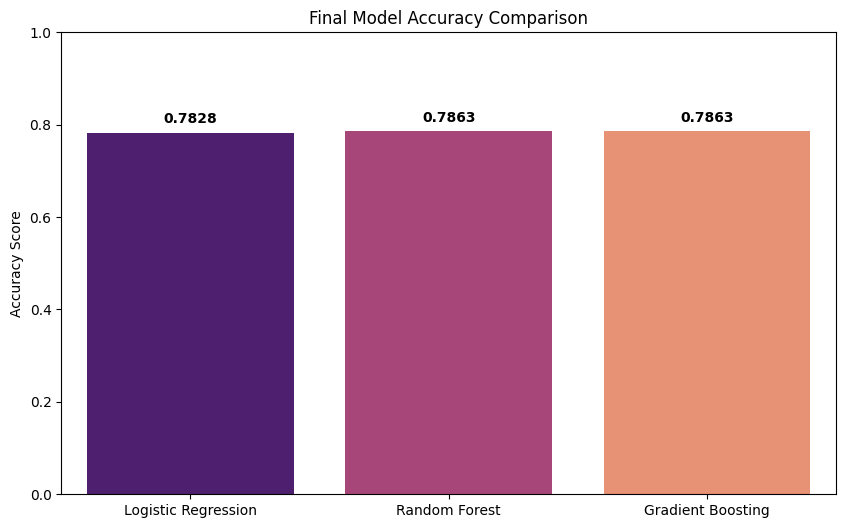

In [21]:
from sklearn.metrics import accuracy_score

# Calculate accuracies
lr_acc = accuracy_score(y_test, lr_model.predict(X_test_scaled))
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))
gb_acc = accuracy_score(y_test, gb_model.predict(X_test))

# Data for plotting
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
accuracies = [lr_acc, rf_acc, gb_acc]

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='magma')

# Add labels and formatting
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.ylabel('Accuracy Score')
plt.title('Final Model Accuracy Comparison')

# Display the values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()